# Exercise 2.1: Binary Classification with JAX and Keras

In diesem Notebook sollten Sie die logistische Regression aus dem ersten Notebook nachbilden, diesmal jedoch das Autodiff-Framework von JAX und Keras verwenden.

In [262]:
import platform
import subprocess
import os
from datetime import datetime

# --- JAX ---
import jax
import jax.numpy as jnp

# --- NumPy ---
import numpy as np

# --- PyTorch ---
import torch

# --- Keras 3 ---
os.environ["KERAS_BACKEND"] = "torch"   # or "jax", depending on usage
import keras

print("=== Python & OS Info ===")
print("Date: {}".format(datetime.now()))
print(f"Python version:      {platform.python_version()}")
print(f"System:              {platform.system()}")
print(f"Machine:             {platform.machine()}")             # arm64 on Apple Silicon
print(f"Processor:           {platform.processor()}")
print(f"Mac version:         {platform.mac_ver()[0]}")           # macOS version
print()
# Optionally: Detect Apple chip
def get_chip_info():
    try:
        out = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
        return out
    except Exception:
        return "unknown"

print(f"Chip:          {get_chip_info()}")
print()

print("=== JAX Info ===")
print(f"JAX version:         {jax.__version__}")
print(f"JAX devices:         {jax.devices()}")
print()

print("=== PyTorch Info ===")
print(f"PyTorch version:     {torch.__version__}")
print(f"CUDA available:      {torch.cuda.is_available()}")
print(f"Device:              {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print()

print("=== NumPy & Keras ===")
print(f"NumPy version:       {np.__version__}")
print(f"Keras version:       {keras.__version__}")
print(f"Keras backend:       {keras.config.backend()}")

=== Python & OS Info ===
Date: 2026-01-06 18:42:15.921256
Python version:      3.12.3
System:              Linux
Machine:             x86_64
Processor:           x86_64
Mac version:         

Chip:          unknown

=== JAX Info ===
JAX version:         0.8.2
JAX devices:         [CpuDevice(id=0)]

=== PyTorch Info ===
PyTorch version:     2.9.1+cu128
CUDA available:      False
Device:              cpu

=== NumPy & Keras ===
NumPy version:       2.4.0
Keras version:       3.13.0
Keras backend:       torch


sysctl: cannot stat /proc/sys/machdep/cpu/brand_string: No such file or directory


### Generate training data

In [263]:
import numpy as np

def generate_training_data(ntrain=200, scale=6.0, seed=None):
    """
    Reproduce the training data (x2, y0) from 01_mlp.ipynb.

    - 2D inputs start uniform on [0, scale]^2
    - Then mapped into four quadrants
    - Labels: quadrants I & III -> 1, quadrants II & IV -> 0
    - Final features x2 are sigmoid-transformed coordinates (perzeptron with w = I, b = 0)
    """
    rng = np.random.default_rng(seed)

    # 2d-Inputs (this is x0 in the notebook)
    x0 = rng.random((ntrain, 2))
    x0 *= scale

    # Quadrant manipulation exactly as in the notebook
    q = ntrain // 4

    # indices [q : 2q): flip x -> quadrant II
    x0[q:2*q, 0] *= -1.0

    # indices [2q : 3q): flip y -> quadrant IV
    x0[2*q:3*q, 1] *= -1.0

    # indices [3q : ntrain): flip both -> quadrant III
    x0[3*q:, :] *= -1.0

    # labels (y0 in the notebook)
    y0 = np.ones(ntrain, dtype=float)
    y0[q:2*q] = 0.0        # quadrant II
    y0[2*q:3*q] = 0.0      # quadrant IV
    # first q and last q remain 1.0 (quadrants I & III)

    # Perzeptron transform with w = I, b = 0 -> this is x2 in the notebook
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    x2 = sigmoid(x0)

    return x2, y0

# In the first notebook a scale of 6.0 was used, here we use 1.0
x2, y0 = generate_training_data(ntrain=200, scale=1.0, seed=42) 

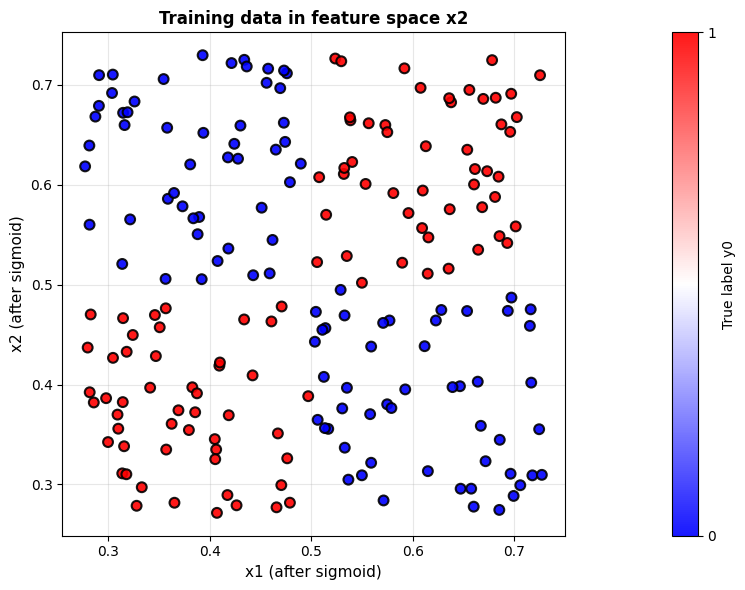

In [264]:
import matplotlib.pyplot as plt

def plot_data_and_probability(x, y, params=None, predict_proba_func=None, figsize=(8, 6)):
    """
    Plot training data and optionally forecasted probability.
    
    Parameters:
    -----------
    x : array-like, shape (n_samples, 2)
        Training data features
    y : array-like, shape (n_samples,)
        Training data labels (0 or 1)
    params : dict, optional
        Model parameters. If None, only data is plotted.
    predict_proba_func : callable, optional
        Function to predict probabilities: predict_proba_func(params, x)
        Required if params is not None.
    figsize : tuple, optional
        Figure size (default: (8, 6))
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid for probability contours (if model is provided)
    if params is not None and predict_proba_func is not None:
        x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
        x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                               np.linspace(x2_min, x2_max, 100))
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]

        # Predict probabilities on the grid
        proba_grid = predict_proba_func(params, grid_points)
        proba_grid = np.array(proba_grid).reshape(xx1.shape)

        # Plot probability contours (reversed colormap: red = high prob for class 1)
        contour = ax.contourf(xx1, xx2, proba_grid, levels=20, cmap='RdYlBu_r', alpha=0.6)
        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.set_label('Forecasted probability p(y=1|x)', fontsize=10)

        # Add decision boundary (p=0.5)
        contour_lines = ax.contour(xx1, xx2, proba_grid, levels=[0.5], colors='black', 
                                   linewidths=2, linestyles='--', zorder=5)
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='p=0.5')
        
        title = 'Training Data and Forecasted Probability'
    else:
        title = 'Training data in feature space x2'

    # Plot training data points
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', 
                         edgecolor='k', linewidth=1.5, s=50, alpha=0.9, zorder=10)
    cbar2 = plt.colorbar(scatter, ax=ax, ticks=[0, 1], pad=0.15)
    cbar2.set_label('True label y0', fontsize=10)

    ax.set_xlabel('x1 (after sigmoid)', fontsize=11)
    ax.set_ylabel('x2 (after sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training data
plot_data_and_probability(x2, y0)

___

### 2.1.1 Logistische Regression mit JAX

Implementieren Sie das logistische Regressionsmodell und die negative Log-Likelihood-Verlustfunktion mit JAX. Stellen Sie sich JAX als Ersatz für NumPy mit automatischer Differentiation vor. Sie können den folgenden Code als Ausgangspunkt verwenden.

#### Parameter Initialisierung: `init_params`

In dieser Funktion werden die Modellparemter $w$ und $b$ initialisiert. Die Gewichte $w$ werden aus einer Normalverteilung gezogen, während der Bias $b$ auf Null gesetzt wird.

In [265]:
# ------------------------------------------------------------
# Parameter initialization (fully implemented)
# ------------------------------------------------------------
def init_params(seed=0):
    """
    Initialize parameters for logistic regression.

    Returns a dictionary:
        params = {
            "w": w,   # shape (2,)
            "b": b    # scalar
        }
    """
    key = jax.random.PRNGKey(seed)
    # Random initialization for weights (small values)
    w = 0.1 * jax.random.normal(key, (2,))
    # Bias initialized to zero
    b = jnp.array(0.0)
    return {"w": w, "b": b}

> **Wichtig**: Durch verwendung eines festen Seeds erzeugt die Funktion bei jedem Aufruf die gleichen initialen Parameter.

In [266]:
# Test the parameter initialization
params = init_params()
print("Initialized parameters:")
print("w:", params["w"])
print("b:", params["b"])
print(f"w shape: {params['w'].shape}, dtype: {params['w'].dtype}")

Initialized parameters:
w: [0.16226421 0.20252648]
b: 0.0
w shape: (2,), dtype: float32


#### Logistische Regression: `predict_proba`

Diese Funktion soll die Klassifikationswahrscheinlichkeit für die Klasse 1, also $P(y=1|x)$ für das logistische Regressionsmodell vorhersagen.

- Eingabe:
    - `params`: Ein Tupel `(W, b)`, wobei `W` die Gewichtsmatrix und `b` der Bias-Vektor ist.
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
- Ausgabe:
    - JAX-Array mit Wahrscheinlichkeiten im Bereich [0, 1] der Form `(n_samples,)` bei einem Batch, bzw. `(1,)` bei einem einzelnen Beispiel.

Als Formel für die logistische Regression gilt:
$$P(y=1|x) = \sigma(w^T x + b)$$
mit 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
als Sigmoid-Funktion.

Die Klasse gibt also die Wahrscheinlichkeit zurück, mit welcher ein Punkt zur Klasse 1 gehört wobei $z = w^T x + b$ einen linearen Score darstellt, der die Entscheidung des Modells repräsentiert welches durch die Sigmoid-Funktion in eine Wahrscheinlichkeit umgewandelt wird.

##### Beispielrechnung
Wir nehmen an, dass die Parameter wie folgt initialisiert wurden:
$$w = \begin{bmatrix} 0.5 & 2 \end{bmatrix}, b = 0$$
Für einen Eingabepunkt
$$x = \begin{bmatrix} 1 & 1 \end{bmatrix}$$
berechnen wir zuerst den linearen Score:
$$z = w^T x + b = \begin{bmatrix} 0.5 \\ 2 \end{bmatrix} \begin{bmatrix} 1 & 1 \end{bmatrix} + 0 = 0.5 + 2 = 2.5$$
Anschließend wenden wir die Sigmoid-Funktion an, um die Wahrscheinlichkeit zu erhalten:
$$P(y=1|x) = \sigma(2.5) = \frac{1}{1 + e^{-2.5}} \approx 0.92$$
Bei diesem Eingabepunkt und dieser Parametrisierung gibt das Modell also eine Wahrscheinlichkeit von etwa 92% aus, dass der Punkt zur Klasse 1 gehört.

In [267]:
# ------------------------------------------------------------
# Model: p(y = 1 | x) given the parameters
# ------------------------------------------------------------
def predict_proba(params, x):
    """
    Compute p(y = 1 | x).
    
    #### Parameters:
    - params: dict with model parameters "w" and "b"
    - x: input features, shape (n_samples, 2)
    #### Returns:
    - p: predicted probabilities for class 1, shape (n_samples,)
    """
    w = params["w"]
    b = params["b"]
    
    # calculate linear score (logit)
    z = jnp.dot(x, w) + b

    # return sigmoid(z) = p
    return jax.nn.sigmoid(z)

In [268]:
# Test predict_proba
params = init_params()
x_test = jnp.array([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]]
Test predict_proba output: [0.5, 0.5454728603363037, 0.5901996493339539]


##### Test mit Beipielwerten
Der folgende Test sollte die oben gezeigte Beispielrechnung bestätigen und eine Ausgabe von etwa 0.92 liefern.

In [269]:
params = {"w": jnp.array([0.5, 2.0]), "b": jnp.array(0.0)}
x_test = jnp.array([[1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[1.0, 1.0]]
Test predict_proba output: [0.9241418242454529]


#### Kostenfunktion: `nll_loss`

Diese Funktion berechnet die negative Log-Likelihood (NLL) für das logistische Regressionsmodell. Sie ist also die Kostenfunktion welche minimiert werden soll um $w$ und $b$ zu lernen.

- Eingabe:
    - `params`: Ein Tupel `(W, b)`, wobei `W` die Gewichtsmatrix und `b` der Bias-Vektor ist.
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
    - `y`: Ein Array mit binären Zielwerten der Form `(n_samples,)`.
- Ausgabe:
    - Skalarwert des negativen Log-Likelihood-Verlusts.

Formel für die negative Log-Likelihood-Verlustfunktion:
$$\text{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i)) + (1 - y_i) \log(1 - p_i) \right]$$
mit
$$p_i = P(y=1|x_i) = \sigma(w^T x_i + b)$$

In [270]:
# ------------------------------------------------------------
# Negative Log-Likelihood loss
# ------------------------------------------------------------
def nll_loss(params, x, y, p_test=None, z_test = None):
    """
    Binary cross-entropy / negative log-likelihood.

    #### Parameters:
    - params: dict with model parameters "w" and "b"
    - x: input features, shape (n_samples, 2)
    - y: true labels, shape (n_samples,)
    #### Returns:
    - loss: scalar, negative log-likelihood loss
    """
    p = predict_proba(params, x) if p_test is None else p_test
    eps = 1e-15  # small constant to avoid log(0)
    return -jnp.mean(y * jnp.log(p + eps) + (1 - y) * jnp.log(1 - p + eps))

    #w = params["w"]
    #b = params["b"]
    #z = jnp.dot(x, w) + b if z_test is None else z_test
    #return jnp.mean(jnp.logaddexp(0, z) - y * z)

> **Wichtig**: Für numerische Stabilität muss sichergestellt werden, dass die Argumente der Logarithmusfunktion nicht exakt 0 oder 1 sind da $\log(0)$ undefiniert ist. Daher wird in der Funktion ein kleiner Wert `eps` verwendet, um die Argumente zu begrenzen.

In [271]:
# Test nll_loss
params = init_params()
loss_test = nll_loss(params, x2, y0)
print("Test nll_loss:", loss_test)

Test nll_loss: 0.69820166


In [272]:
params = {"w": jnp.array([0.5, 0.5]), "b": jnp.array(0.0)}
print("Initialized parameters:")
print("w:", params["w"])
print("b:", params["b"])

aL = 0.0179862106
zL = -4.0

x = jnp.array([[1.0, 1.0]])
y = jnp.array([1.0])
loss_test = nll_loss(params, x, y, aL, zL)
print("Test nll_loss with custom params:", loss_test)

grad_f = jax.grad(nll_loss, argnums=0)
grads = grad_f(params, x, y)
print("Gradient w.r.t. w:", grads["w"])
print("Gradient w.r.t. b:", grads["b"])
grads

Initialized parameters:
w: [0.5 0.5]
b: 0.0
Test nll_loss with custom params: 4.01815
Gradient w.r.t. w: [-0.2689414 -0.2689414]
Gradient w.r.t. b: -0.2689414


{'b': Array(-0.2689414, dtype=float32, weak_type=True),
 'w': Array([-0.2689414, -0.2689414], dtype=float32)}

#### Trainingsfunktion: `train`

Die Trainingsfunktion implementiert den Full-Batch-Gradientenabstieg zur Optimierung der Modellparameter $w$ und $b$.

Die Funktion erstellt also ein Netzwerk mit einem einzigen Neuron Outputneuron (logistische Regression) und optimiert die Parameter mittels Gradientenabstieg basierend auf der negativen Log-Likelihood-Verlustfunktion.

- Eingabe:
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
    - `y`: Ein Array mit binären Zielwerten der Form `(n_samples,)`.
    - `n_steps`: Anzahl der Trainingsschritte (Standard: 1000).
    - `learning_rate`: Lernrate für den Gradientenabstieg (Standard: 0.1).
- Ausgabe:
    - Ein Tupel `(W, b)` mit den trainierten Modellparametern. 

In [273]:
# ------------------------------------------------------------
# Full-batch gradient descent training loop
# ------------------------------------------------------------
def train(x, y, lr=0.1, n_steps=2000, init_seed=0):
    """
    Full-batch gradient descent training.

    TODO:
      - Initialize params = init_params()
      - Define grad_loss = jax.grad(nll_loss)
      - Loop over steps:
          * compute gradients
          * update w and b
      - Print loss every 200 steps (optional)
      - Return final params
    """
    # Initialize parameters
    params = init_params(init_seed)

    # Define gradient function using JAX
    grad_loss = jax.grad(nll_loss)

    for step in range(n_steps):
        # Compute gradients
        grads = grad_loss(params, x, y)

        # Update parameters
        params["w"] -= lr * grads["w"]
        params["b"] -= lr * grads["b"]
        
        # Optional: Print loss every 200 steps
        if step % 200 == 0:
            current_loss = nll_loss(params, x, y)
            print(f"Step {step}, Loss: {current_loss:.4f}")
    return params

Step 0, Loss: 0.6979
Step 200, Loss: 0.6935
Step 400, Loss: 0.6934
Step 600, Loss: 0.6932
Step 800, Loss: 0.6931
Step 1000, Loss: 0.6930
Step 1200, Loss: 0.6929
Step 1400, Loss: 0.6928
Step 1600, Loss: 0.6928
Step 1800, Loss: 0.6927


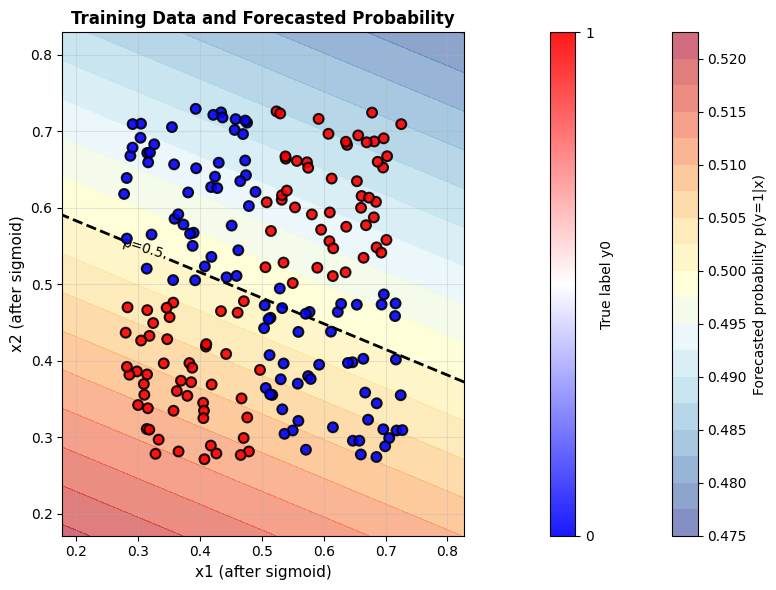

In [274]:
# ------------------------------------------------------------
# After students implement everything:
params = train(x2, y0)
# ------------------------------------------------------------
# Plot the data and forecasted probability
plot_data_and_probability(x2, y0, params, predict_proba)

In [275]:
x_test = jnp.array([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]]
Test predict_proba output: [0.532130777835846, 0.4991241693496704, 0.46612513065338135]


#### Bewertung des Trainings

Das Training zeigt, dass der Verlust sich nur wenig verändert was zum einen an den Daten sowie an der Einfachheit des Modells liegt.

Das Modell ist geometrisch Betrachtet nichts anderes als eine lineare Entscheidungsgrenze die die zwei Klassen trennt, also wie folgt aufgebaut ist:
$$z = w^T x + b = 0$$
was nichts anderes als eine Gerade in 2D ist.

> **Hinweis**: Da die Daten nicht linear trennbar sind, kann das Modell nicht perfekt trainiert werden. Das erstellte "Netzwerk" ist eigentlich nur ein einzelnes Neuron mit einer Sigmoid-Aktivierungsfunktion also ein einziges Perzeptron. Ein einzelnes Perzeptron (auch binärer Klassifikator genannt) kann nur linear trennbare Daten korrekt klassifizieren.

___

### 2.1.2 Multilayer Perceptron

Fügen Sie dem Modell eine versteckte Ebene der Dimension 16 hinzu und wiederholen Sie [2.1.1](#211-logistische-regression-mit-jax). 

Um die Leistung zu verbessern, verwenden Sie jit, indem Sie den Aktualisierungsschritt in eine jit-Funktion einfügen.

```python
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        # YOUR CODE HERE
        }
```

In diesem Abschnitt soll ein kleines MLP implementiert werden, das aus einer versteckten Schicht mit 16 Neuronen und einer Ausgabeschicht besteht. Bislang hatten wir in Aufgabenteil [2.1.1](#211-logistische-regression-mit-jax) nur ein einzelnes Neuron (logistische Regression):
$$x \rightarrow \text{Linear} \rightarrow \text{Sigmoid} \rightarrow \hat{y}$$
Nun erweitern wir das Modell zu einem MLP mit einer versteckten Schicht:
$$x \rightarrow \text{Linear (W1, b1)} \rightarrow \text{ReLU} \rightarrow \text{Linear (W2, b2)} \rightarrow \text{Sigmoid} \rightarrow \hat{y}$$
Der Output bleibt weiterhin eine Wahrscheinlichkeit für die Klasse 1.
Als Kostenfunktion verwenden wir erneut die binäre negative Log-Likelihood (NLL).

#### Anpassung der Parameter Initialisierung: `init_params_mlp`
Um die Parameter für die geforderte MLP-Architektur zu initialisieren, muss die Funktion `init_params` angepasst werden. Die Funktion sollte die Gewichte und Biases für zwei Schichten initialisieren: eine Eingabeschicht mit 2 Neuronen, eine versteckte Schicht mit 16 Neuronen und eine Ausgabeschicht mit 1 Neuron.

In [276]:
import jax
import jax.numpy as jnp

# ------------------------------
# MLP Parameter-Initialization
# ------------------------------
def init_mlp_params(hidden_dim: int = 16, seed: int = 0):
    """
    Initialize parameters for a simple MLP with one hidden layer.
    
    Parameters
    ----------
    hidden_dim : int
        Number of neurons in the hidden layer.
    seed : int
        Random seed for initialization.

    Returns
    -------
    params : dict
        Dictionary containing initialized weights and biases:
        {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    """
    # generate different keys for each parameter
    key = jax.random.PRNGKey(seed)
    k1, k2 = jax.random.split(key, 2)
    
    # Initialize weights and biases from input to hidden layer
    W1 = 0.1 * jax.random.normal(k1, (2, hidden_dim))
    b1 = jnp.zeros((hidden_dim,))

    # Initialize weights and biases from hidden to output layer
    W2 = 0.1 * jax.random.normal(k2, (hidden_dim, 1))
    b2 = jnp.zeros((1,))
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [277]:
# Test the MLP parameter initialization
import pandas as pd
mlp_params = init_mlp_params()
pd_mlp_params = pd.DataFrame({k: [v.shape, v.dtype] for k, v in mlp_params.items()}, index=["shape", "dtype"])
print("Initialized parameters:")
print(pd_mlp_params)
print(f"shape of x2: {x2.shape}, dtype: {x2.dtype}")

Initialized parameters:
            W1       b1       W2       b2
shape  (2, 16)    (16,)  (16, 1)     (1,)
dtype  float32  float32  float32  float32
shape of x2: (200, 2), dtype: float64


#### Anpassung der Vorhersagefunktion: `predict_proba`
Da das Modell jetzt eine versteckte Schicht enthält, muss die Vorhersagefunktion ebenfalls angepasst werden. 
Die Funktion soll die Eingabedaten durch die erste Schicht (Eingabe zu versteckt) mit einer Aktivierungsfunktion (hier ReLu) und dann durch die zweite Schicht (versteckt zu Ausgabe) leiten, um die Wahrscheinlichkeit zu bestimmen.

Für das Netzwerk ergibt sich also folgende verschachtelte Funktion:
$$P(y=1|x) = \sigma(W_2 \cdot \text{ReLU}(W_1 x + b_1) + b_2)$$
wobei in jedem Schritt zuerst die lineare Transformation mit:
$$z_i = W_i x + b_i = w_i^\top x + b_i$$
durchgeführt wird, gefolgt von der Aktivierungsfunktion (ReLU für die versteckte Schicht und Sigmoid für die Ausgabeschicht). 

`jnp.dot` erwartet als erstes Argument eine Matrix der Form (m, n) und als zweites Argument ein Array der Form (n,) oder (n, p). Daher wird zuerst `x` übergeben (Shape: `200, 2`), gefolgt von `W1` (Shape: `2, 16`).

In [278]:
# ------------------------------
# MLP Predict Probability
# ------------------------------
def mlp_prdict_proba(params, x, hidden_activation=jax.nn.relu, debug=False):
    """
    Compute p(y = 1 | x) using the MLP.
    
    Parameters:
    -----------
    params : dict
        MLP parameters with keys "W1", "b1", "W2", "b2"
    x : array-like, shape (n_samples, 2)
        Input features

    Returns:
    --------
    p : array-like, shape (n_samples,)
        Predicted probabilities for class 1
    """
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    # Forward pass: Input to hidden layer
    z1 = jnp.dot(x, W1) + b1            # Linear transformation
    h1 = hidden_activation(z1)          # Activation function
    print(f"z1 shape: {z1.shape}, h1 shape: {h1.shape}") if debug else None

    # Forward pass: Hidden to output layer
    z2 = jnp.dot(h1, W2) + b2           # Linear transformation (logits)
    
    #return z2.squeeze()

    # Sigmoid to get probabilities
    p = jax.nn.sigmoid(z2).squeeze()
    print(f"z2 shape: {z2.shape}, p shape: {p.shape}") if debug else None

    return p

In [279]:
# Test the MLP predict_proba
params = init_mlp_params()
x_test = jnp.array([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]])
proba_test = mlp_prdict_proba(params, x_test, debug=True)
print(f"Test mlp_prdict_proba input: {x_test.tolist()}")
print("Test mlp_prdict_proba output:", proba_test.tolist())

z1 shape: (3, 16), h1 shape: (3, 16)
z2 shape: (3, 1), p shape: (3,)
Test mlp_prdict_proba input: [[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]]
Test mlp_prdict_proba output: [0.5, 0.48868462443351746, 0.47738081216812134]


#### Anpassung der Kostenfunktion: `nll_loss`

Die Kostenfunktion bleibt unverändert, da sie bereits die Vorhersagefunktion als Eingabe verwendet. Durch die Anpassung der Vorhersagefunktion wird automatisch die korrekte Berechnung der negativen Log-Likelihood für das MLP gewährleistet.

In [280]:
# -------------------------------------
# Numerisch stabile NLL (BCE-with-logits)
# -------------------------------------
def nll_loss_mlp(params, x, y, hidden_activation=jax.nn.relu):
    p = mlp_prdict_proba(params, x, hidden_activation=hidden_activation)
    return -jnp.mean(y * jnp.log(p + 1e-15) + (1 - y) * jnp.log(1 - p + 1e-15))

    # numerically stable version using logits
    #y = jnp.asarray(y)
    #z = mlp_logits(params, x)
    #return jnp.mean(jnp.logaddexp(0.0, p) - y * p)

> Eine von GPT empfolhlene Optimierung ist die nummerisch Stabilere implementierung bei welcher die Logits direkt verwendet werden anstatt die Wahrscheinlichkeiten. Hierbei würde die `predict_proba` Funktion durch eine `predict_logits` Funktion ersetzt werden um die Logits zurückzugeben und die `nll_loss` Funktion würde die Logits verwenden um die NLL zu berechnen (siehe auskommentierter Code in `nll_loss_mlp` und `mlp_predict_proba`). Da ich die mathematische Herleitung von `logaddexp` nicht blicke berechne ich in der Loss-Funktion nach wie vor die Wahrscheinlichkeiten und nutze diese um die NLL zu berechnen.

#### Update Methode
Anschließend wird die in der Aufgabenbeschreibung gezeigte `update`-Methode genutzt um die Parameter des MLP mittels Gradientenabstieg (`jax.grad`) zu optimieren.

In [281]:
# ------------------------------
# jit-kompiliertes Update
# ------------------------------
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss_mlp)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        "b1": params["b1"] - lr * grads["b1"],
        "W2": params["W2"] - lr * grads["W2"],
        "b2": params["b2"] - lr * grads["b2"],
    }

#### Training des MLP

Da das Parameterupdate nun in einer extra Funktion gekapselt ist, kann die Trainingsfunktion entsprechend gekürtzt werden.

Step 0, MLP Loss: 0.6932
Step 200, MLP Loss: 0.6926
Step 400, MLP Loss: 0.6922
Step 600, MLP Loss: 0.6915
Step 800, MLP Loss: 0.6904
Step 1000, MLP Loss: 0.6884
Step 1200, MLP Loss: 0.6850
Step 1400, MLP Loss: 0.6793
Step 1600, MLP Loss: 0.6698
Step 1800, MLP Loss: 0.6546
Step 2000, MLP Loss: 0.6317
Step 2200, MLP Loss: 0.6003
Step 2400, MLP Loss: 0.5621
Step 2600, MLP Loss: 0.5219
Step 2800, MLP Loss: 0.4849
Step 3000, MLP Loss: 0.4540
Step 3200, MLP Loss: 0.4299
Step 3400, MLP Loss: 0.4117
Step 3600, MLP Loss: 0.3981
Step 3800, MLP Loss: 0.3880


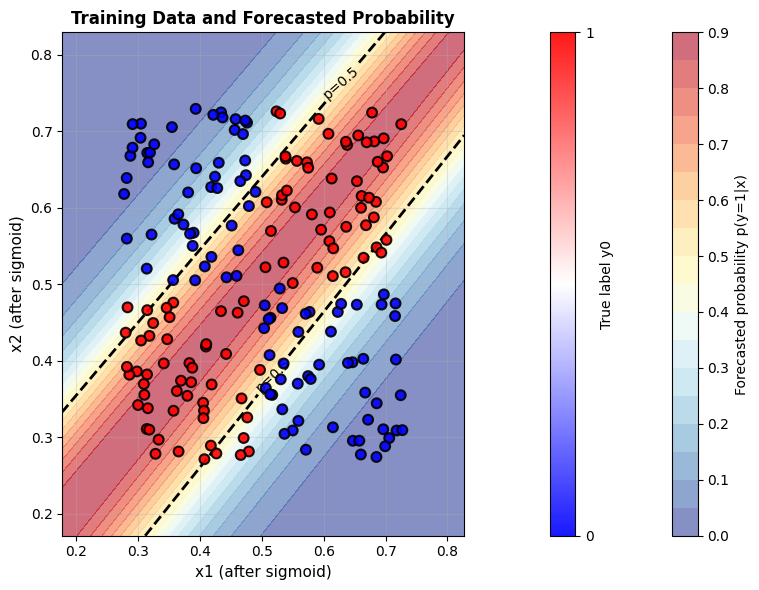

In [282]:
# Kleiner Trainingslauf für das MLP
def train_mlp(x_train, y_train, lr=0.1, n_steps=4000, seed=0, hidden_activation=jax.nn.relu):
    # generate network parameters
    params = init_mlp_params(hidden_dim=16, seed=seed)

    # Training loop
    for step in range(n_steps):
        params = update(params, x_train, y_train, lr)
        if step % 200 == 0:
            current_loss = nll_loss_mlp(params, x_train, y_train, hidden_activation=hidden_activation)
            print(f"Step {step}, MLP Loss: {current_loss:.4f}")
    return params

# Trainieren und Visualisieren
params_mlp = train_mlp(x2, y0)
plot_data_and_probability(x2, y0, params_mlp, mlp_prdict_proba)

##### Bewertung des Trainings
Das Training des MLP zeigt eine deutliche Verbesserung gegenüber der einfachen logistischen Regression auch wenn dies noch besser gehen könnte (siehe folgendes [Tensorflow-Playground Experiment](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=8&seed=0.48605&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)).

___

### 2.1.3 Implementieren Sie das MLP in Keras.

Implementieren Sie das MLP in Keras unter Verwendung der sequenziellen API.

#### Model definieren

In [283]:
import keras
from keras import layers

model = keras.Sequential([
  layers.Input(shape=(2,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

#### Loss und Optimierung

Lossfunktionen in Keras [Losses](https://keras.io/api/losses/)

In [284]:
eta = 0.1

model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=eta),
  loss=keras.losses.BinaryCrossentropy(),
  metrics=["accuracy"]
)

#### Training

In [292]:
history = model.fit(
    x2, y0,
    epochs=500,
    batch_size=len(x2),   # complete batch like in exercises before
    #batch_size=32,
    #validation_split=0.2,
    verbose=0
)

print(f"Final train acc: {history.history['accuracy'][-1]:.4f}")
if 'val_accuracy' in history.history:
    print(f"Final val acc:   {history.history['val_accuracy'][-1]:.4f}")

Final train acc: 0.8100


#### Wahrscheinlichkeiten für Plot


Mit der folgenden Funktion (erstellt mit GPT 5.2) kann der Output des Keras Netzwerk auch mit der bereitgestellten Funktion geplottet werden.

In [290]:
def predict_proba_keras(model, x):
    preds = model.predict(np.asarray(x), verbose=0)
    return preds.ravel()

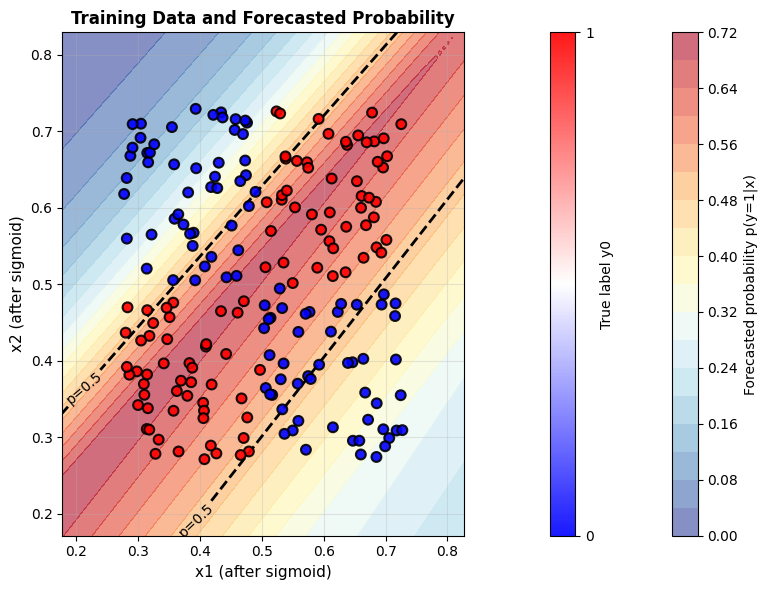

In [293]:
plot_data_and_probability(x2, y0, model, predict_proba_keras)